**Title**: Asteroid Flybys

**Author**: Reto Hendry

**Course**: NoSQL Lab with Python & MongoDB

![description](C:\Users\retoh\switchdrive\Studium_Master\04_FS23\noSQL_Lab\project\images\earth_asteroid.jpg)


Source: https://www.chron.com/news/space/article/nasa-asteroid-passing-earth-17853976.php

\newpage

# Table of Contents


- [2 Introduction and Motivation](#Introduction-and-Motivation)
- [3 Requirements and Configuration](#Requirements-and-Configuration)
- [4 ELT Process](#ELT-Process)
  * [4.1 DB Setup](#DB-Setup)
  * [4.2 Extract](#Extract)
  * [4.3 Load](#Load)
  * [4.4 Transform](#Transform)
  * [4.5 Some minor quality checks](#Some-minor-quality-checks)
  * [4.6 Data structure](#Data-structure)
- [5 Data analysis](#Data-analysis)
  * [5.1 Get a feeling for asteroids](#Get-a-feeling-for-asteroids)
  * [5.2 Close approach count](#Close-approach-count)
  * [5.3 Brightest asteroids](#Brightest-asteroids)
- [6 Conclusions and Outlook](#Conclusions-and-Outlook)
- [7 Learnings](#Learnings)

\newpage

# Introduction and Motivation

The used API in this small project work in the noSQL course provides information about asteroids which have a close approach to our planet - the Earth.

Since I have a big telescope (Dobson: 1.2 meter length, 0.2m diameter) in my vacation-flat in the mountains this API is perfect to figure out when I should take it out during the next two years to see my first asteroid through my telescope.

With that said, the goal is to discover the asteroid dataset, find interesting fact about them and determine the night I should "asteroid"-gaze.

\newpage

#  Requirements and Configuration

In [514]:
! pip3 list | findstr "pymongo dnspython pandas"

dnspython                         2.3.0
pandas                            1.5.3
pymongo                           4.3.3


In [1]:
import pymongo
import pprint as pp
import pandas as pd
import requests
import json
import time
import string
import tqdm as tqdm
import random
import matplotlib.pyplot as plt
import configparser

In [516]:
# pandas display configuration
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_colwidth', 50)

In [2]:
# API details
# note: the API needs a start date and an API key (end date it 7 days after start date by default)
config = configparser.ConfigParser()
config.read('config.ini')

API_KEY = config['api']['api_key']

def get_API(start_date="2023-04-01"):
    START_DATE = start_date  # YYYY-MM-DD
    API_URL = f"https://api.nasa.gov/neo/rest/v1/feed?start_date={START_DATE}&api_key={API_KEY}"

    return API_URL


# mongoDB details
CNX_STR = API_KEY = config['mongoDB_conection']['cnx_str']
DB_NAME = "Asteroids_DB"
COLL_NAME = "asteroids"

\newpage

# ELT Process

## DB Setup

In [519]:
# connection to MongoDB
client = pymongo.MongoClient(CNX_STR)
db = client[DB_NAME]
ast = db[COLL_NAME]

In [520]:
# show server info
client.server_info()

{'version': '5.0.15',
 'gitVersion': '935639beed3d0c19c2551c93854b831107c0b118',
 'modules': ['enterprise'],
 'allocator': 'tcmalloc',
 'javascriptEngine': 'mozjs',
 'sysInfo': 'deprecated',
 'versionArray': [5, 0, 15, 0],
 'bits': 64,
 'debug': False,
 'maxBsonObjectSize': 16777216,
 'storageEngines': ['devnull',
  'ephemeralForTest',
  'inMemory',
  'queryable_wt',
  'wiredTiger'],
 'ok': 1.0,
 '$clusterTime': {'clusterTime': Timestamp(1680806843, 28),
  'signature': {'hash': b'k4\x87\xe1Oj\x89wL\x0c\x16\x14lL\xfbI~\x1d\xcf\xcc',
   'keyId': 7181751485795926018}},
 'operationTime': Timestamp(1680806843, 28)}

In [521]:
# count and drop already existing documents in the database
print(f"Documents before drop: {ast.count_documents({})}")
ast.drop()
print(f"Documents after drop: {ast.count_documents({})}")

Documents before drop: 7424
Documents after drop: 0


\newpage

##  Extract

In [523]:
# Check how the structure of the API looks like
answer = requests.get(get_API())
# pp.pprint(answer.json())
# the output is shown as a figure in the report, since otherwise it would be too long in the pdf printout

![description](C:\Users\retoh\switchdrive\Studium_Master\04_FS23\noSQL_Lab\project\images\request_output.jpg)


The following explanation of the data selection is done by looking at the data as if it were a python dictionary: After looking at the structure of the data, it is clear that the only valuable content is inside the key "near_earth_object" and there again, inside the date key (here "2023-04-01"). The date key itself is not needed, since the information of the date is provided in the "close_approach_date" key, inside the list of the key "close_approach_data" too. 

To extract the data needed, a loop is needed which changes the start date of the API request every iteration. I decided to analyze asteroid flybys for the next 2 years. To later save the data into mongoDB, the documents requested will be saved into a list iteratively. Only the needed information of the requested json-file will be added to the list as a document. 

Since the data is less than 200 MB, it is possible to store the requested data in memory of the computer and load them into the mongoDB. Otherwise one possible solution would have been to store the data into files on the computer in a first step. Then iteratively, read the data into python, transform and load them up into the mongoDB.

In [212]:
# create a list of dates with an 8 day interval
date_list = (pd.date_range(start="2023-04-01", end="2025-04-01", freq="8D")
                .strftime("%Y-%m-%d")
                .tolist()
            )

# create a list of documents with the data from the API
asteroid_list = []
for k, date in enumerate(tqdm.tqdm(date_list)):
    # if the API is called too fast, it will return an error
    time.sleep(random.randint(10, 15))
    answer = requests.get(get_API(date))
    # loop through the 7 days
    for i in answer.json()["near_earth_objects"]:
        asteroid_count = len(answer.json()["near_earth_objects"][i])
        # loop through the asteroids of each day
        for j in range(asteroid_count):
            # append each asteroid to the list
            asteroid_list.append(answer.json()["near_earth_objects"][i][j])

100%|██████████| 92/92 [22:15<00:00, 14.51s/it]


In [524]:
# Quick check if every date ("close_approach_date") is in the list
date_list = [i["close_approach_data"][0]["close_approach_date"] for i in asteroid_list]
date_set = sorted(set(date_list))
first_date = date_set[0]
last_date = date_set[-1]
print(f"first date: {first_date}",
      f"last date: {last_date}",
      sep="\n")

# count the number of days between 2000-01-01 and 2050-01-01
day_count = len(pd.date_range(start=first_date, end=last_date, freq="D")
                .strftime("%Y-%m-%d").tolist())

print(f"days in the set: {len(date_set)}",
      f"number of days in this time period: {day_count}",
      sep="\n")

assert len(date_set) == day_count, "Not every day was requested from the API"

first date: 2023-04-01
last date: 2025-04-05
days in the set: 736
number of days in this time period: 736


In [552]:
# save the data_list to a json file (for backup)
# with open("asteroid_list.json", "w") as f:
#     json.dump(asteroid_list, f)

In [530]:
# print the first document (dictionary) of the list
pp.pprint(asteroid_list[0])

{'_id': ObjectId('642c7ab38da3f7e0511c7139'),
 'absolute_magnitude_h': 17.54,
 'close_approach_data': [{'close_approach_date': '2023-04-01',
                          'close_approach_date_full': '2023-Apr-01 03:37',
                          'epoch_date_close_approach': 1680320220000,
                          'miss_distance': {'astronomical': '0.2394279959',
                                            'kilometers': '35817918.205008733',
                                            'lunar': '93.1374904051',
                                            'miles': '22256222.3378491954'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '44539.9893358747',
                                                'kilometers_per_second': '12.37221926',
                                                'miles_per_hour': '27675.4172626162'}}],
 'estimated_diameter': {'feet': {'estimated_diameter_max': 6053.7576380301,
               

The document (dictionary) looks nice and only contains the part needed. However, there are still some type errors and unnecessary fields in the document, which will be treated in the transform phase later on.

\newpage

## Load

After requesting the data and having it stored in memory, the data is now loaded into the mongoDB.

In [531]:
# insert data into mongoDB chunk by chunk with 1000 documents each
# (without the chunk by chunk method, an error occurred)

asteroid_chunk_list = [asteroid_list[i:i + 1000] for i in range(0, len(asteroid_list), 1000)]

# insert the chunks into mongoDB
for chunk in tqdm.tqdm(asteroid_chunk_list):
    ast.insert_many(chunk)
    time.sleep(10)

100%|██████████| 8/8 [01:41<00:00, 12.72s/it]


In [532]:
# check the number of documents in the database
print(f"Documents in the database: {ast.count_documents({})}")

Documents in the database: 7424


In [533]:
# get the first document from MongoDB
pp.pprint(ast.find_one())

{'_id': ObjectId('642c7ab38da3f7e0511c7139'),
 'absolute_magnitude_h': 17.54,
 'close_approach_data': [{'close_approach_date': '2023-04-01',
                          'close_approach_date_full': '2023-Apr-01 03:37',
                          'epoch_date_close_approach': 1680320220000,
                          'miss_distance': {'astronomical': '0.2394279959',
                                            'kilometers': '35817918.205008733',
                                            'lunar': '93.1374904051',
                                            'miles': '22256222.3378491954'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '44539.9893358747',
                                                'kilometers_per_second': '12.37221926',
                                                'miles_per_hour': '27675.4172626162'}}],
 'estimated_diameter': {'feet': {'estimated_diameter_max': 6053.7576380301,
               

As shown in the output, also when calling a document from the mongoDB, the document looks as expected. 

\newpage

## Transform

As already mentioned above, some fields are not needed for the analysis. To keep the size of a document as small as possible, those fields will be removed. 

Some numerical fields are stored as strings. They will be changed to integers or doubles. 

In [534]:
# remove the links from all the documents since they are not needed
ast.update_many({}, 
                {"$unset": {"links": ""}})

# remove "epoch_date_close_approach" since it is not needed
ast.update_many({}, {
    "$unset": {"close_approach_data.0.epoch_date_close_approach": ""}
})

# remove all the irrelevant units from "miss_distance"
ast.update_many({}, {
    "$unset": {"close_approach_data.0.miss_distance.astronomical": ""}
})
ast.update_many({}, {
    "$unset": {"close_approach_data.0.miss_distance.miles": ""}
})

# remove all the irrelevant units from "relative_velocity"
ast.update_many({}, {
    "$unset": {"close_approach_data.0.relative_velocity.miles_per_hour": ""}
})

# remove all the irrelevant units from "estimated_diameter"
ast.update_many({}, {
    "$unset": {"estimated_diameter.feet": ""}
})
ast.update_many({}, {
    "$unset": {"estimated_diameter.miles": ""}
})

Change the types of string fields which should be integers or floats.

In [535]:
# change the type of "id" and "neo_reference_id" from string to int
ast.update_many({}, [{"$set": {"id": {"$toInt": "$id"}}}])
ast.update_many({}, [{"$set": {"neo_reference_id": {"$toInt": "$neo_reference_id"}}}])

# the next 4 were tricky, since the fields to change are nested in an object.
# thanks to Oliver for helping with this!

# change the field "kilometers" and "lunar" in the object "miss distance" 
# from string to float
ast.update_many({},[
    {"$addFields": {"x": {"$first": "$close_approach_data"}} },
    {"$set": {"x":{"$toDouble": "$x.miss_distance.kilometers"}}},
    {"$set": {"close_approach_data.miss_distance.kilometers": "$x"}},
    {"$unset": "x"}
])

ast.update_many({},[
    {"$addFields": {"x": {"$first": "$close_approach_data"}} },
    {"$set": {"x":{"$toDouble": "$x.miss_distance.lunar"}}},
    {"$set": {"close_approach_data.miss_distance.lunar": "$x"}},
    {"$unset": "x"}
])

# change the filed "kilometers_per_hour" and "kilometers_per_second" in the object
# "relative_velocity" from string to float
ast.update_many({},[
    {"$addFields": {"x": {"$first": "$close_approach_data"}} },
    {"$set": {"x":{"$toDouble": "$x.relative_velocity.kilometers_per_hour"}}},
    {"$set": {"close_approach_data.relative_velocity.kilometers_per_hour": "$x"}},
    {"$unset": "x"}
])

ast.update_many({},[
    {"$addFields": {"x": {"$first": "$close_approach_data"}} },
    {"$set": {"x":{"$toDouble": "$x.relative_velocity.kilometers_per_second"}}},
    {"$set": {"close_approach_data.relative_velocity.kilometers_per_second": "$x"}},
    {"$unset": "x"}
])


The "id" and "neo_reference_id" seem to be the same. This will be check, if it actually always it the same. If it is, the "neo_reference_id" will be removed from the document.

In [536]:
# check how many times "id" and "neo_reference_id" are different
different_id_count = ast.count_documents({
    "$expr": {"$ne": ["$id", "$neo_reference_id"]}
})

if different_id_count == 0:
    # delete the field "neo_reference_id" since it is not needed
    ast.update_many({}, {"$unset": {"neo_reference_id": ""}})

In [537]:
# check document structure after the transformation
pp.pprint(ast.find_one())

{'_id': ObjectId('642c7ab38da3f7e0511c7139'),
 'absolute_magnitude_h': 17.54,
 'close_approach_data': [{'close_approach_date': '2023-04-01',
                          'close_approach_date_full': '2023-Apr-01 03:37',
                          'miss_distance': {'kilometers': 35817918.20500873,
                                            'lunar': 93.1374904051},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': 44539.9893358747,
                                                'kilometers_per_second': 12.37221926}}],
 'estimated_diameter': {'kilometers': {'estimated_diameter_max': 1.845185269,
                                       'estimated_diameter_min': 0.8251919385},
                        'meters': {'estimated_diameter_max': 1845.1852690256,
                                   'estimated_diameter_min': 825.1919385245}},
 'id': 2069230,
 'is_potentially_hazardous_asteroid': True,
 'is_sentry_object': False,
 'nam

Now the document only contains the needed information from my point of view. Of course one could make the document even more minimalistic, but for now, this is all right. 

\newpage

## Some minor quality checks

In [538]:
# get all the documents where the "close_approach_data" array has more than one element
plus_size_array = ast.count_documents({
    "close_approach_data": {"$size": 2}
})

if plus_size_array == 0:
    print("No documents with more than one element in the 'close_approach_data' array")

No documents with more than one element in the 'close_approach_data' array


In [539]:
# check if there are any documents with empty string or None in the field "id"
# if one is found, print the document and delete it
empty_id_count = ast.count_documents({"id": {"$in": ["", None]}})

if empty_id_count > 0:
    for doc in ast.find({"id": {"$in": ["", None]}}):
        pp.pprint(doc)
        ast.delete_one({"_id": doc["_id"]})
            
print(f"{empty_id_count} documents deleted")

0 documents deleted


In [540]:
# check for duplicates in the id field
pipeline = [
    {"$group": {"_id": "$id", "count": {"$sum": 1}}},
    {"$match": {"count": {"$gt": 1}}},
    {"$project": {"id": "$_id", "_id": 0, "count": 1}},
    {"$sort": {"count": -1}}
]

result = ast.aggregate(pipeline)
df = pd.DataFrame(result).head()

if len(df) > 0:
    print("Duplicates found")
    print(df.T, "\n")
    dup = ast.find({"id": int(df.loc[0, "id"])},
                   {"_id": 0, "id": 1, "name": 1, 
                   "close_approach_data.close_approach_date_full": 1})
    for doc in dup:
        pp.pprint(doc)

else:
    print("No duplicates found in the 'id' field")
    nbr_unique_id = ast.distinct("id")
    print("There are {} unique id values".format(len(nbr_unique_id)))

Duplicates found
             0        1         2        3        4
count        5        5         5        5        5
id     3843427  3824978  54194978  2519354  3763284 

{'close_approach_data': [{'close_approach_date_full': '2023-Apr-06 09:13'}],
 'id': 3843427,
 'name': '(2019 OV3)'}
{'close_approach_data': [{'close_approach_date_full': '2023-Sep-26 04:14'}],
 'id': 3843427,
 'name': '(2019 OV3)'}
{'close_approach_data': [{'close_approach_date_full': '2024-Mar-18 02:35'}],
 'id': 3843427,
 'name': '(2019 OV3)'}
{'close_approach_data': [{'close_approach_date_full': '2024-Oct-09 16:52'}],
 'id': 3843427,
 'name': '(2019 OV3)'}
{'close_approach_data': [{'close_approach_date_full': '2025-Feb-27 06:41'}],
 'id': 3843427,
 'name': '(2019 OV3)'}


As it can be see, duplicates are present in the *id* field. However, when looking at the documents where the *id* is the same, it can be observed, that it is not the same approach of the asteroid. Therefore the duplicates of the *id* fields will not be deleted. In other words, these are not the same documents, they only have the same *id*.

In [541]:
# check if the "estimated_diameter_min" and "estimated_diameter_max" are correctly related
# (min has to be smaller than max)
# note: $expr has to be used to compare numerical values
false_relation_count = ast.count_documents({
        "$expr":{
                "$lte": [
                        "$estimated_diameter.meters.estimated_diameter_max",
                        "$estimated_diameter.meters.estimated_diameter_min"
                ]
        }
})

print(f"{false_relation_count} documents with wrong estimated_diameter_min/estimated_diameter_max relation")

0 documents with wrong estimated_diameter_min/estimated_diameter_max relation


\newpage

## Data structure

After transforming the data, this is how the diagram of the document structure looks. It contains the entire structure with all its information.

![description](C:\Users\retoh\switchdrive\Studium_Master\04_FS23\noSQL_Lab\project\images\data_structer_diagram_V04.png)


\newpage

# Data analysis

**In this analysis, the following questions should be answered:**

- extreme values of the asteroids to get a feeling about them

- how many asteroids have a close approach to earth during the next 2 years and how many of them are classified as hazardous

- which ones are the brightest 15 and when can they be seen. Also add a few key information to it.

- check if there is a pattern between hazardous and non-hazardous asteroids

## Get a feeling for asteroids

What are the minimum and maximum values of the interesting fields such as diameter, speed, miss distance, ect.. Each asteroid with such an "extreme" value will be inserted into a new collection called "extreme_asteroids".

In [542]:
# create a new collection for the documents with the extreme values
extreme = db["extreme_asteroids"]
extreme.delete_many({})
extreme.count_documents({})

0

In [543]:
field_list = [
    "close_approach_data.miss_distance.lunar", 
    "close_approach_data.relative_velocity.kilometers_per_second",
    "estimated_diameter.kilometers.estimated_diameter_min",
    "estimated_diameter.kilometers.estimated_diameter_max"
]                                   

for field in field_list:
    pipeline = [
        {"$unwind": "$close_approach_data"},  # not every time needed (but no harm)
        {"$sort": {field: 1}},
        {"$group": {
            "_id": "null",
            "min_doc": {"$first": "$$ROOT"},  # $$ROOT contains the source documents
            "max_doc": {"$last": "$$ROOT"}
        }},
        {"$project": {
            "_id": 0,
            "min_doc": 1,
            "max_doc": 1
        }}
    ]

    ans = ast.aggregate(pipeline)

    for answer in ans:
        try:
            extreme.insert_one(answer["min_doc"])
            extreme.insert_one(answer["max_doc"])
        except pymongo.errors.DuplicateKeyError:
            print(
"""
DuplicateKeyError:
The asteroids with the minimal and maximal "estimated_diameter_min" 
and "estimated_diameter_max" are exactly the same.
"""
            )



DuplicateKeyError:
The asteroids with the minimal and maximal "estimated_diameter_min" 
and "estimated_diameter_max" are exactly the same.



In [544]:
# print the documents with the extreme values
pipeline = [
    {"$unwind": "$close_approach_data"},
    {"$project": {
        "_id": 0,
        "id": 1,
        "miss_dist [lunar]": "$close_approach_data.miss_distance.lunar", 
        "vel [km/s]": "$close_approach_data.relative_velocity.kilometers_per_second",
        "diam min [km]": "$estimated_diameter.kilometers.estimated_diameter_min",
        "diam max [km]": "$estimated_diameter.kilometers.estimated_diameter_max",
        "magnitude": "$absolute_magnitude_h"
    }}
]

pd.set_option('display.float_format', lambda x: '%.4f' % x)

result = extreme.aggregate(pipeline)
df = pd.DataFrame(result)
df

,id,miss_dist [lunar],vel [km/s],diam min [km],diam max [km],magnitude
0,3398066,1.1588,4.7659,0.0101,0.0226,27.1000
1,3669357,194.4812,19.9933,0.0058,0.0130,28.3000
2,54024339,141.2080,0.9401,0.2469,0.5521,20.1600
3,2343158,189.3456,78.6574,1.4810,3.3116,16.2700
4,3989456,36.2519,19.3498,0.0008,0.0018,32.5600
5,2001036,145.5238,16.3344,38.2433,85.5145,9.2100


In [545]:
print(
    f"The maximum miss lunar distance is {df['miss_dist [lunar]'].max():.4f}.",
    f"The minimum miss lunar distance is {df['miss_dist [lunar]'].min():.4f}.",
    "note: 1 lunar distance is the distance between the earth and the moon.",
    f"The maximum velocity is {df['vel [km/s]'].max():.4f} kilometers per second.",
    f"The minimum velocity is {df['vel [km/s]'].min():.4f} kilometers per second.",
    f"The maximum diameter is {df['diam max [km]'].max():.4f} kilometers, which is {df['diam max [km]'].max()/12.742:.2f} times the diameter of the Earth.",
    f"The minimum diameter is {df['diam min [km]'].min():.4f} kilometers, which is only {df['diam min [km]'].min()*1000:.4f} meters.",
    sep = "\n"
)

The maximum miss lunar distance is 194.4812.
The minimum miss lunar distance is 1.1588.
note: 1 lunar distance is the distance between the earth and the moon.
The maximum velocity is 78.6574 kilometers per second.
The minimum velocity is 0.9401 kilometers per second.
The maximum diameter is 85.5145 kilometers, which is 6.71 times the diameter of the Earth.
The minimum diameter is 0.0008 kilometers, which is only 0.8176 meters.


The asteroid with the biggest diameter is also the brightest one during those two years, as shown below.

In [546]:
pd.set_option('display.float_format', lambda x: '%.2e' % x)

\newpage

## Close approach count

How many asteroids have a close approach to the earth during the next two years?

In [547]:
# count the number of unique asteroids approaching Earth
pipeline = [
    {"$group": {"_id": "$name"}},
    {"$group": {"_id": "null", "count": {"$sum": 1}}},
    {"$project": {"count": 1, "_id": 0}}
]

ans = ast.aggregate(pipeline)
pd.DataFrame(ans)

,count
0,5522


In [548]:
# count the number of unique asteroids approaching Earth which are potentially hazardous
pipeline = [
    {"$match": {"is_potentially_hazardous_asteroid": True}},
    {"$group": {"_id": "$name"}},
    {"$group": {"_id": "null", "count": {"$sum": 1}}},
    {"$project": {"count": 1, "_id": 0}}
]

ans = ast.aggregate(pipeline)
pd.DataFrame(ans)

,count
0,574


In [549]:
# count the number of documents
ast.count_documents({})

7424

There are 7424 documents, asteroid approaches respectively during the next 2 years. The number of unique asteroids approaching Earth is 5522 and 574 of them are potentially hazardous.

\newpage

## Brightest asteroids

Note: Magnitude is a measure of a star's brightness as seen from Earth. It is expressed using a numerical scale where lower numbers indicate brighter stars. The brightest star in the night sky, Sirius, has a magnitude of -1.4, while the faintest stars visible to the naked eye have a magnitude of around +6.5. The scale is logarithmic, meaning that a difference of 1 magnitude corresponds to a difference in brightness of about 2.5 times.

In [550]:
pipeline = [
    {"$sort": {"absolute_magnitude_h": 1}},
    {"$limit": 15},
    {"$unwind": "$close_approach_data"},
    {"$project": {
        "id": 1, 
        "magnitude": "$absolute_magnitude_h", 
        "date_n_time": "$close_approach_data.close_approach_date_full", 
        "dist_lunar": "$close_approach_data.miss_distance.lunar",
        "hazardous": "$is_potentially_hazardous_asteroid",
        "_id": 0
    }}
]

ans = ast.aggregate(pipeline)
df = pd.DataFrame(ans)
df

,id,magnitude,date_n_time,dist_lunar,hazardous
0,2001036,9.21e+00,2024-Oct-13 01:56,1.46e+02,False
1,2004954,1.26e+01,2024-Oct-11 05:00,9.43e+01,False
2,2000887,1.38e+01,2025-Jan-08 13:40,3.20e+01,False
3,2003122,1.39e+01,2024-Oct-01 03:49,1.48e+02,True
4,2001685,1.43e+01,2024-Jan-20 20:46,5.18e+01,False
5,2021088,1.43e+01,2024-Jul-22 17:06,1.35e+02,False
6,2066146,1.44e+01,2024-Nov-05 19:47,3.46e+01,False
7,2137170,1.47e+01,2025-Mar-03 18:59,8.88e+01,False
8,2001864,1.48e+01,2024-Aug-13 15:16,1.92e+02,False
9,2030825,1.48e+01,2024-May-01 22:35,8.70e+01,False


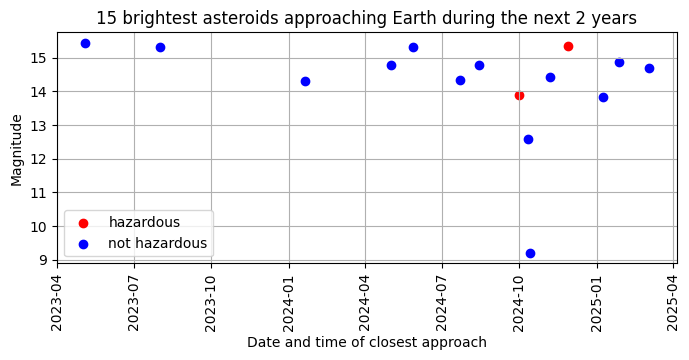

In [555]:
# create plot with the closest asteroids
fig, ax = plt.subplots(figsize=(8, 3))

# change the format of the date
df["date_n_time"] = pd.to_datetime(df["date_n_time"], format="%Y-%b-%d %H:%M")

# create the plot
ax.scatter(df.loc[df["hazardous"]==1,"date_n_time"], df.loc[df["hazardous"]==1,"magnitude"], color="red")
ax.scatter(df.loc[df["hazardous"]==0,"date_n_time"], df.loc[df["hazardous"]==0,"magnitude"], color="blue")

ax.set_xlabel("Date and time of closest approach")
ax.set_ylabel("Magnitude")
ax.set_title("15 brightest asteroids approaching Earth during the next 2 years")
ax.tick_params(axis="x", rotation=90)
ax.legend(["hazardous", "not hazardous"])
ax.grid()

plt.show()

The plot shows, it will be hard to observe asteroids this year. The ones this year are very rare (only two) and they are not bright. A better time for asteroid-gazing will be in October 2024, since there is the brightest asteroid during the next two years as well as more asteroids to observe in general. Interestingly, one of those during October 2024 is potentially hazardous as well. 

\newpage

# Conclusions and Outlook

**Conclusion**: This API brings quite some potential for some interesting analysis. Unfortunately during the next two years, it is not clear whether I will be able to see an asteroid through my telescope. The problem is to find it in the sky, since none of them is visible by the naked eye. The smallest asteroid is not even 1 meter in diameter, whereas the biggest in diameter is 85.5145 kilometers, which is 6.71 times the diameter of the Earth. The velocities of the asteroids range from roughly 1 to 79 kilometers per second which is not really imaginable. The asteroid with the maximum speed would orbit the earth in almost exactly 2 seconds.

**Outlook**: At the end of the project when my time started to run out due to the time needed for my master thesis, the project started to really make fun. Especially when I started to look at the numbers and graphs. Once my master thesis is handed in, I might do some further work on it. For sure I will extend the time period to find an asteroid which han be seen from the naked eye. 

# Learnings

**SQL**: It is not such a damn struggle as we were thought in the Database Management Course (which was horrible). It is actually quite doable and really useful. Also the combination with python works really well. After my masters degree, I will continue to learn SQL on DataCamp since I realized that it really important and not as hard. 

**noSQL - mongoDB**: The noSQL database handling is actually not too hard and comes with quite some freedom. Once the syntax of pymongo gets more familiar, it is also not that hard to do pipelines. A big learning for me was especially when and how to use databases in general and what the advantages are. I did not understand the difference between a csv and a database at the beginning of this course. It now makes all sense why databases and database management is so important. I also learned and realized (in mongoDB at least) that setting up a database in the cloud and connecting to it via python is quite straight forward and easy.

**Print to PDF**: I have worked entirely with minicona and conda environments. As an IDE I used Visual Studio Code, which is the best IDE for me by far. It can also run Jupyter Notebooks and easily change the environments. To print the pdf is also relatively convenient, just install MiKTeX onto your computer. Except one thing cost my hours to get it work; the images have to be inserted in markdown cells as markdown code. The catch is, when printing the notebook to a pdf, the path needs to be absolute and not relative! Therefore the notebook will not show the image anymore, but it will appear in the generated pdf. Note: On Linux, the abs path works either way. Another mistake happened as I finally wanted to print the pdf again 4 hours before hand in which cost me another 2 hours; Do not und the "&" sign in titles and in the table of content.